# 딥러닝을 적용하여 핸드폰 인물 사진 모드를 따라 해 보자.

- 들어가며, 인물사진 모드란?

- 셸로우 포커스 만들기 (1) 사진을 준비하자

- 셸로우 포커스 만들기 (2) 세그멘테이션으로 사람 분리하기

- 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기

- 셸로우 포커스 만들기 (4) 세그멘테이션 결과를 원래 크기로 복원하기

- 셸로우 포커스 만들기 (5) 배경 흐리게 하기

- 셸로우 포커스 만들기 (6) 흐린 배경과 원본 영상 합성

- 프로젝트: 인물 모드 문제점 찾기

- 프로젝트 제출

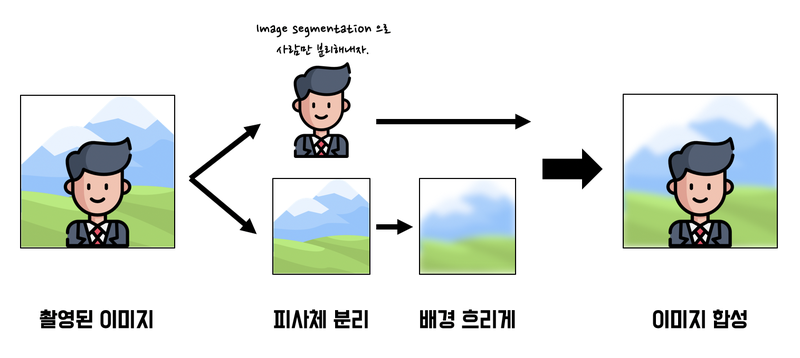

- 1) 배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
- 2) 시멘틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.
- 3) 블러링(blurring) 기술로 배경을 흐리게 합니다.
- 4) 피사체를 배경의 원래 위치에 합성합니다.

## 1. 사진을 준비하자

In [179]:
# 필요한 모듈 import 하기

import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [180]:
# 이미지 불러오기

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1875, 1875, 3)


## 2. 세그멘테이션으로 사람 분리하기 

### 이미지 세그맨테이션

- 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 <b>이미지 세그멘테이션(image segmentation)</b>. 
- 이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정. 
- 이때 공통 특징은 물리적 의미가 없을 수도 있습니다. 픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있는 것이죠. 물론 세그멘테이션에는 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출합니다.

### 시맨틱 세그맨테이션
- 세그멘테이션 중에서도 특히 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 <b>시맨틱 세그멘테이션</b> 
- 쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법이라고 이해

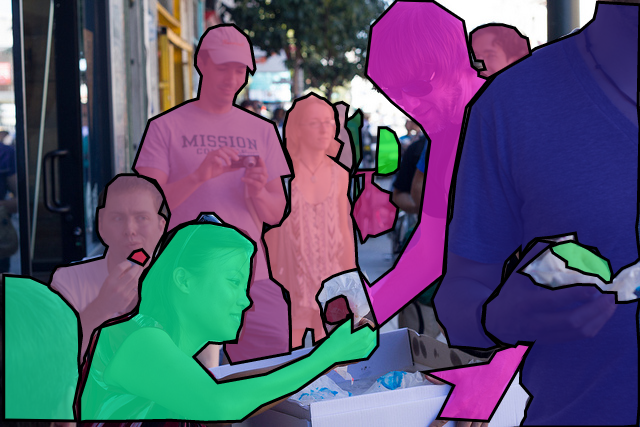

### 인스턴스 세그맨테이션
- 시맨틱 세그멘테이션은 '사람'이라는 추상적인 정보를 이미지에서 추출해내는 방법입니다. 
- 그래서 사람이 누구인지 관계없이 같은 라벨로 표현이 됩니다.
- 더 나아가서 <b>인스턴스 세그멘테이션</b>은 사람 개개인별로 다른 라벨을 가지게 합니다. 
- 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표

In [181]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

- preprocess(): 전처리, run(): 실제로 세그멘테이션을 하는 함수. 
- 먼저 input tensor를 만들기 위해 preprocess() 함수에서 이미지 전처리

- 모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize 하고, OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정합니다.
- 전처리된 이미지는 run() 함수에서 입력값으로 사용되는 것을 볼 수 있습니다.

In [182]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [183]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1875, 1875, 3) (513, 513, 3) 15


cv2는 이미지를 HWC(Height, Width, Channel) 순서   
img_orig은 크기는 (1875, 1875, 3) / img_resized의 크기는 (513, 513, 3)

In [184]:
#  구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습. 제공하는 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

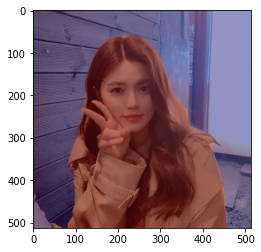

In [185]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 사람을 뜻하는 15 외 예측은 0으로 만들었습니다. 그럼 예측된 세그멘테이션 이미지(map)는 최댓값이 15가 됩니다. 
- 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 합니다. 
- applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력

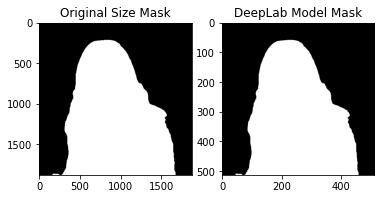

In [186]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

왼쪽은 원본크기, 오른쪽은 deeplab 모델 입출력 크기

- cv2.resize() 함수를 이용합니다. 크기를 키울 때 보간(interpolation) 을 고려해야 하는데요, 
- cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용합니다. 
- 여기서 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법

- img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻습니다. 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정합니다. 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법

## 3. 블러링(blurring) 기술로 배경 흐리게 하기

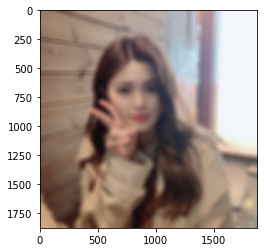

In [192]:
img_orig_blur = cv2.blur(img_orig, (50,50)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

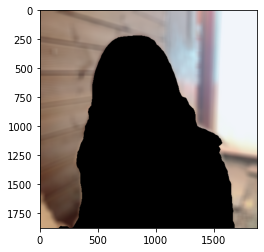

In [193]:
# 흐려진 이미지에서 배경만 추출하기
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 4. 피사체를 배경의 원래 위치에 합성

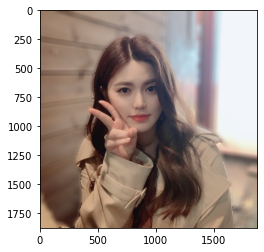

In [194]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

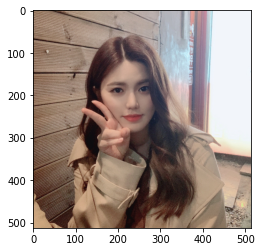

In [195]:
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
plt.show()

(-0.5, 1874.5, 1874.5, -0.5)

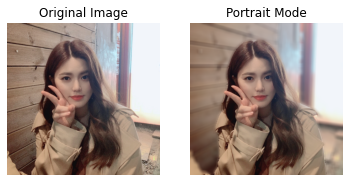

In [196]:
fig = plt.figure()
rows = 1
cols = 2
ax1 = fig.add_subplot(rows, cols, 1)
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
ax2.set_title('Portrait Mode')
ax2.axis("off")

---

# 프로젝트

- 1) 배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
- 2) 시멘틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.
- 3) 블러링(blurring) 기술로 배경을 흐리게 합니다.
- 4) 피사체를 배경의 원래 위치에 합성합니다.

## 1. 사진을 준비하자

In [197]:
# 필요한 모듈 import 하기

import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [198]:
# 이미지 불러오기

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bf.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1440, 1080, 3)


## 2. 세그멘테이션으로 사람 분리하기

In [199]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [200]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1440, 1080, 3) (513, 384, 3) 15


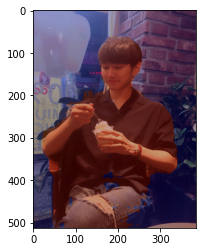

In [201]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

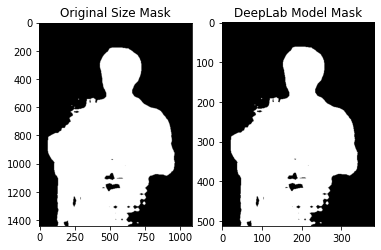

In [202]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## 3. 블러링(blurring) 기술로 배경 흐리게 하기

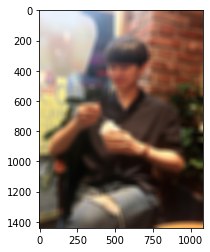

In [203]:
img_orig_blur = cv2.blur(img_orig, (40,40)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

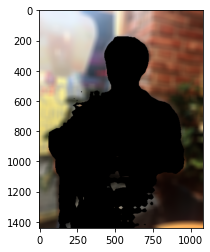

In [204]:
# 흐려진 이미지에서 배경만 추출하기
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 4. 피사체를 배경의 원래 위치에 합성

(-0.5, 1079.5, 1439.5, -0.5)

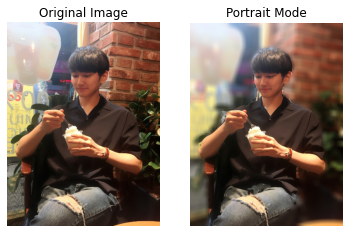

In [205]:
fig = plt.figure()
rows = 1
cols = 2
ax1 = fig.add_subplot(rows, cols, 1)
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
ax2.set_title('Portrait Mode')
ax2.axis("off")